# Simple Reinforcement Learning in Tensorflow Part 1: The Multi-armed bandit

In this iPython notebook we implement a simple policy-gradient based agent that can solve the multi-armed bandit problem using pyTorch. For more details see original tutorial containing tensorflow code on [Medium](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1-fd544fab149).

In [41]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

### The Bandit
Here we define our bandit. For this example we are using a four-armed bandit. The pullBandit function generates a random number from a normal distribution with a mean of 0. The lower the bandit number, the more likely a positive reward will be returned. We want our agent to learn to always choose the arm that will give that positive reward.

In [21]:
# Bandit arms with arm 4 providing best reward
bandit_arms = [0.2, 0, -0.2, -2]
n = len(bandit_arms)

def pullBandit(bandit, bandit_arms=bandit_arms):
    # Get a random number.
    result = np.random.randn(1)
    return 1 if result > bandit_arms[bandit] else -1

Let's try to pull each arm 1000 times and see what reward we get.

In [104]:
reward = np.zeros(n).astype('int')
for _ in range(1000):
    reward += np.array([pullBandit(i) for i in range(n)])
print('Arm rewards {0}, total reward {1}'.format(reward, reward.sum()))

Arm rewards [-168  -24  120  954], total reward 882


### The Agent

The code below established our simple neural agent. It consists of a set of values for each of the bandit arms. Each value is an estimate of the value of the return from choosing the bandit. We use a policy gradient method to update the agent by moving the value for the selected action toward the recieved reward.

We will train our agent by taking actions in our environment, and recieving rewards. Using the rewards and actions, we can know how to properly update our network in order to more often choose actions that will yield the highest rewards over time.

$$Loss = - \log(Policy) * Advantage$$

In [105]:
weights = torch.ones(n, requires_grad=True)
adam = torch.optim.Adam([weights], lr=1e-3)
soft_max = torch.nn.Softmax(dim=0)

total_reward = np.zeros(n)
pulls = []

# Repeat for number of episodes
for i in range(4000):
    # Choose action according to Boltzmann distribution.
    action = np.random.choice(range(n), p=soft_max(weights).detach().numpy())
    # Get our reward from picking one of the bandit arms
    reward = pullBandit(action)
    pulls.append(action.item())

    # Update the network
    loss = -torch.log(weights[action]) * reward
    adam.zero_grad()
    loss.backward()
    adam.step()

    # Update our running tally of scores.
    total_reward[action] += reward

print('Weights:', weights)

Weights: tensor([ 0.7411,  1.0127,  1.2418,  3.3679])


## How rewards change over time?

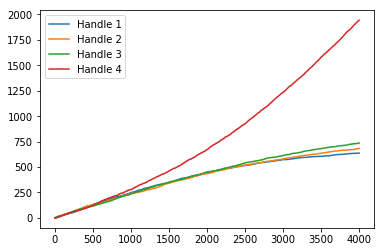

Final rewards [-109    1  117 1853], total reward 1862


In [109]:
pulls = np.array(pulls)
for i in range(n):
    plt.plot(np.cumsum(pulls == i), label='Handle {0}'.format(i+1))
plt.legend()
plt.show()
print('Final rewards {0}, total reward {1}'.format(total_reward.astype('int'), total_reward.sum().astype('int')))